In [27]:
%cd /data/soyeonhong/vq2d/vq2d-lightning
%load_ext autoreload
%autoreload 2

/data/soyeonhong/vq2d/vq2d-lightning
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from IPython.display import Image as IPImage

from ltvu.lit.model import LitModule
from ltvu.lit.data import LitVQ2DDataModule

import hydra
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf

import torch
import torchvision.transforms.functional as TF
from einops import rearrange, repeat
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
from transformers import Dinov2Model

backbone = Dinov2Model.from_pretrained('facebook/dinov2-base')
down_rate = 14
backbone_dim = 768

def ten2pil(tensor, pad: float = 0.02, alpha = None, cmap = 'viridis'):
    assert tensor.dim() in (2, 3)  # (H, W), (C, H, W)
    tensor = tensor.cpu()
    tensor -= tensor.min()
    tensor /= tensor.max()

    if tensor.dim() == 3:
        tensor = tensor.permute(1, 2, 0)
        assert tensor.shape[-1] == 3

    fig = plt.figure(figsize=(5, 5))
    ax = plt.Axes(fig, [pad, pad, 1. - 2* pad, 1. - 2 * pad])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(tensor, aspect='equal', alpha=alpha, cmap=cmap)

    plots_io = BytesIO()
    fig.savefig(plots_io, format='jpg' if alpha is None else 'png', bbox_inches='tight', pad_inches=0)
    plt.close()

    img = Image.open(plots_io)
    # plots_io.close()
    return img

GlobalHydra.instance().clear()
OmegaConf.clear_resolvers()
OmegaConf.register_new_resolver("job_type", lambda : 'debug')
OmegaConf.register_new_resolver('runtime_outdir', lambda : 'outputs/tmp')
OmegaConf.register_new_resolver("eval", eval)
OmegaConf.register_new_resolver("tuple", lambda *args: tuple(args))
hydra.initialize(config_path='config', job_name='asdasdasdasdasd')

/tmp/ipykernel_1909214/3084222404.py:55: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path='config', job_name='asdasdasdasdasd')


hydra.initialize()

In [29]:
# path_ckpt = 'outputs/batch/2024-10-19/133186/epoch=54-prob_acc=0.7952.ckpt'
# path_ckpt = 'outputs/batch/2024-10-21/133643/epoch=22-prob_acc=0.7899.ckpt'
path_ckpt = 'outputs/ckpt/epoch=56-prob_acc=0.7935.ckpt'  # 57242
plm = LitModule.load_from_checkpoint(path_ckpt).cuda()
plm.eval()
plm.freeze()

eval_config = hydra.compose(config_name='base', overrides=[
    #f'ckpt={path_ckpt.replace('=', '\\=')}',
    f'+experiment=[rt_pos_query]',
    f'batch_size=1',
    f'num_workers=4',
    f'prefetch_factor=1'
])
pdm = LitVQ2DDataModule(eval_config)  # won't use trainer here nor batched forward pass so no need to load the eval config and plm.config is enough
pdm.batch_size = 1

segment
query
gt_bboxes
gt_probs
before_query_mask
seg_idxs
clip_fps
query_frame
dict_keys(['segment', 'query', 'gt_bboxes', 'gt_probs', 'before_query_mask', 'video_uid', 'clip_uid', 'annotation_uid', 'seg_idxs', 'query_set', 'clip_fps', 'query_frame', 'visual_crop', 'object_title', 'experiment'])


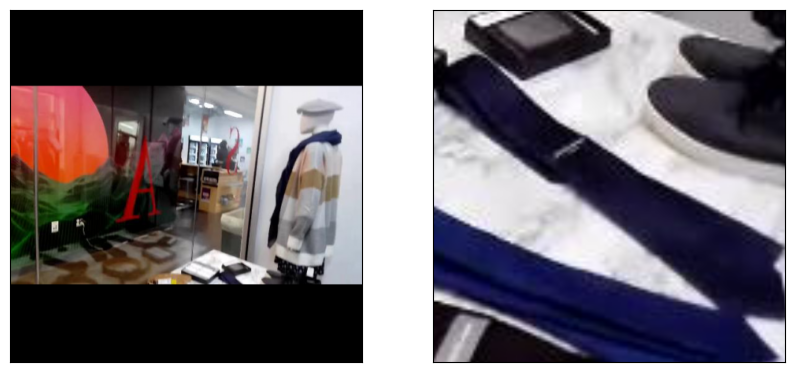

In [39]:
# get
# bidx = 300  # mean iou: 0 vs. 0.450
# bidx = 1307  # mean iou:
# bidx = 2300
bidx = 2305

batch = pdm.get_train_sample(idx=bidx)
for k, v in batch.items():
    if isinstance(v, torch.Tensor) or k == 'experiment':
        batch[k] = v.cuda()

# viz
print(batch.keys())
seg = rearrange(batch['segment'][0], 't c h w -> t h w c').cpu().numpy()
q = rearrange(batch['query'][0], 'c h w -> h w c').cpu().numpy()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
ax.imshow(seg[len(seg) // 2])
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax = axes[1]
ax.imshow(q)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.show()

In [31]:
# with torch.inference_mode():
#     inputs = dict(**batch)
#     inputs['segment'], inputs['query'] = pdm.normalize(inputs['segment'], inputs['query'])
#     # output_dict = plm_base.model.forward(**inputs, compute_loss=True, get_intermediate_features=True, training=False)
#     output_dict = plm.model.forward(**inputs, compute_loss=True, 
#                                     get_intermediate_features=True, 
#                                     training=False)
# output_dict.keys()

In [32]:
def extract_feature(x):
    b, _, h_origin, w_origin = x.shape
    
    with torch.inference_mode():
        x_forward_outs = backbone.forward(x, output_hidden_states=True)
    feat = x_forward_outs.last_hidden_state
    hidden_states = x_forward_outs.hidden_states[-2]
    cls_token = rearrange(feat[:, :1, :], 'b 1 c -> b c 1')
    feat = feat[:, 1:, :]  # we discard the [CLS] token   # [b, h*w, c]
    h = int(h_origin / down_rate)
    w = int(w_origin / down_rate)
    
    return {
            'feat': feat,
            'cls': cls_token,
            'h': h, 'w': w,
            'hidden_states': hidden_states
        }

In [42]:
import kornia
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [43]:
rt_pos_queries = batch['experiment']['multi_query']['rt_pos_queries']
bsz = rt_pos_queries.shape[0]
rt_pos_queries = rearrange(rt_pos_queries, 'b q c h w -> (b q) c h w')
rt_pos_queries = kornia.enhance.Normalize(mean=MEAN, std=STD)
rt_pos_queries = rearrange(rt_pos_queries, '(b q) c h w -> b q c h w', b=bsz)
batch['rt_pos_queries'] = rt_pos_queries
batch['rt_pos_idx'] = batch['experiment']['multi_query']['rt_pos_idx']

rt_pos_queries = rearrange(rt_pos_queries, 'b t c h w -> (b t) c h w') # [b*t,c,h,w]
rt_pos_queries_feat_dict = extract_feature(rt_pos_queries)

RuntimeError: Tensor type unknown to einops <class 'kornia.enhance.normalize.Normalize'>

In [38]:
b, t = batch['segment'].shape[:2]
device = batch['segment'].device
rt_pos_queries_cls = rt_pos_queries_feat_dict['cls']
rt_pos_queries_cls = rearrange(rt_pos_queries_cls.squeeze(-1), '(b t) c -> b t c', b= b, t=t) # [b,t,c]
valid_gt_mask = rt_pos_idx != -1  # [b,t]

# sim between rt_pos_queries
_norms = torch.norm(rt_pos_queries_cls, dim=-1, keepdim=True)  # [b,t,1]
_cls = rt_pos_queries_cls / torch.maximum(_norms, torch.tensor(1e-6, device=device))  # [b,t,c]
simmat = torch.einsum('bsc,btc->bst', _cls, _cls)  # [b,t,t]
sim = []  # [b,t]
for bidx in range(b):
    sim.append(simmat[bidx, valid_gt_mask[bidx]].mean(dim=0))  # [t]
sim = torch.stack(sim)  # [b,t]

sim_thr = 0.0
sim_mask = (sim > sim_thr) & valid_gt_mask # [b,t]
sim_mask_num = sim_mask.sum() / b
batch_has_valid = sim_mask.any(dim=-1) # [b]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [24]:
rt_pos_queries.device

device(type='cpu')